In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
sys.path.append('..')


In [157]:
import pandas as pd
import autograd.numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

from utils.models import BNN, BNN_LV
from utils.functions import gaussian, log_gaussian
from utils.training import HMC


## Set up Data and PDFs

In [ ]:
# Use the test data from HW8
data = pd.read_csv('../data/HW8_data.csv')
X_train = np.array(data['x']).reshape(12,1)
y_train = np.array(data['y']).reshape(12,1)


# Set up the prior, likelihood and posterior
def log_prior(W, mu, sigma):
    """ Generate the prior PDF """
    return np.sum(log_gaussian(x=W, mu=mu, sigma=sigma), axis=-1)

def log_likelihood(W, X, Y, sigma, nn):
    """ Generate the likelihood PDF """
    mu = nn.forward(X, weights=W)
    llh = np.sum(log_gaussian(x=Y, mu=mu, sigma=sigma), axis=0)
    return llh

def create_log_posterior(X, Y, p_mu, p_sigma, l_sigma, nn):
    """ Wrapper to create an initialized posterior PDF """
    def log_posterior(W, X=X, Y=Y, p_mu=p_mu, p_sigma=p_sigma, l_sigma=l_sigma, nn=nn):
        """ Generate the posterior PDF """
        log_p = log_prior(W=W, mu=p_mu, sigma=p_sigma)
        log_l = log_likelihood(W=W, X=X, Y=Y, sigma=l_sigma, nn=nn)
        llh = log_p + log_l
        return llh 
    return log_posterior

## Training a Normal BBN using HMC

In [8]:
architecture = {'input_n':1, 
             'output_n':1, 
             'hidden_layers':[5],
             'biases' : [1,1],
             'activations' : ['relu', 'linear']}
test_bnn = BNN(architecture=architecture)

test_bnn.fit(X_train, y_train, step_size=0.01, max_iteration=5000, check_point=500, regularization_coef=None)

Iteration 0 lower bound 8.270221573071824; gradient mag: 39.81349086568352
Iteration 500 lower bound 0.21468046918372719; gradient mag: 0.08972862453621828
Iteration 1000 lower bound 0.17480607571747417; gradient mag: 0.020097951754889282
Iteration 1500 lower bound 0.17210057684170232; gradient mag: 0.0355516754171641
Iteration 2000 lower bound 0.1713699390457405; gradient mag: 0.03156536237073467
Iteration 2500 lower bound 0.17037468704891212; gradient mag: 0.028202054065995408
Iteration 3000 lower bound 0.16882120494487665; gradient mag: 0.03097983261646821
Iteration 3500 lower bound 0.16622729552778234; gradient mag: 0.11302695979267065
Iteration 4000 lower bound 0.16297964962239017; gradient mag: 0.22833521568953527
Iteration 4500 lower bound 0.15948681876949597; gradient mag: 0.0072848668730278844


In [170]:
# Set up the target function
log_posterior_bnn = create_log_posterior(X_train, y_train, 0, 5, 0.25, test_bnn)

# Run HMC from initial starting weights
mle_weights = test_bnn.get_weights()
random_weights_test = np.random.uniform(-1,1, size=test_bnn.get_weights().shape)

hmc = HMC(log_target_func=log_posterior_bnn, position_init=random_weights_test, total_samples=1000, leapfrog_steps=20, step_size=1e-3,
    burn_in=0.75, thinning_factor=1, mass=1.0, random_seed=None, progress=False)

bayesian_weights = hmc.sample()

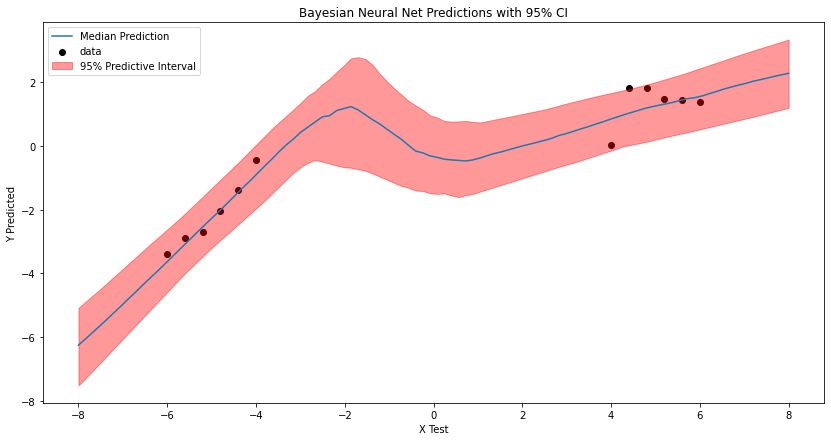

In [171]:
# Visualize the Posterior Predictive

# Set up data
x_test_q3 = np.linspace(-8, 8, 100)

# Take 100 random posterior samples
w_random_samples = bayesian_weights[np.random.choice(bayesian_weights.shape[0], 100), :]
noise_samples = np.random.normal(loc=0, scale=0.5, size=100)

y_preds = []

# Loop through the samples of weights
for i in range(w_random_samples.shape[0]):
    # Create the same NN for predictions but with weights from the samples
    w_cur = w_random_samples[i,:]

    mu_pred = test_bnn.forward(x_test_q3.reshape(-1,1), w_cur)
    y_pred = mu_pred + noise_samples[i]
    y_preds.append(y_pred.reshape(-1))

# Calculate percentiles
y_lower = np.percentile(y_preds, q=2.5, axis=0)
y_upper = np.percentile(y_preds, q=97.5, axis=0)
y_med = np.percentile(y_preds, q=50, axis=0)

# Plot with confidence
plt.figure(figsize=(14,7))
plt.scatter(X_train.flatten(), y_train.flatten(), color='black', label='data')
plt.plot(x_test_q3, y_med, label="Median Prediction")
plt.fill_between(x_test_q3, y_lower, y_upper, alpha=0.4, color='r', label="95% Predictive Interval")
plt.title("Bayesian Neural Net Predictions with 95% CI")
plt.xlabel("X Test")
plt.ylabel("Y Predicted")
plt.legend()
plt.show()

## Training a BNN+LV using HMC

In [173]:
# Set up the prior, likelihood and posterior
def log_prior(W, mu, sigma):
    """ Generate the prior PDF """
    return np.sum(log_gaussian(x=W, mu=mu, sigma=sigma), axis=-1)


# Set up the prior, likelihood and posterior
def log_latent_prior(z, mu, gamma):
    """ Generate the prior PDF """
    return np.sum(log_gaussian(x=z, mu=mu, sigma=gamma), axis=-1)


def log_likelihood(W, X, Y, mu, sigma):
    """ Generate the likelihood PDF """
    llh = np.sum(log_gaussian(x=Y, mu=mu, sigma=sigma), axis=0)
    return llh

def create_log_posterior(X, Y, p_mu, p_sigma, l_sigma, nn):
    """ Wrapper to create an initialized posterior PDF """
    def log_posterior(W, X=X, Y=Y, p_mu=p_mu, p_sigma=p_sigma, l_sigma=l_sigma, nn=nn):
        """ Generate the posterior PDF """
        
        mu_l = nn.forward(X, weights=W)
        z = nn.last_input_noise

        log_p = log_prior(W=W, mu=p_mu, sigma=p_sigma)
        log_zp = log_latent_prior(z=z, mu=0, gamma=gamma)
        log_l = log_likelihood(W=W, X=X, Y=Y, mu=mu_l, sigma=l_sigma)
        llh = log_p + log_l + log_zp

        return llh 
    return log_posterior

log_posterior_bnn = create_log_posterior(X_train, y_train, 0, 5, 0.25, test_bnn)

In [174]:
architecture = {'input_n':1, 
             'output_n':1, 
             'hidden_layers':[5],
             'biases' : [1,1],
             'activations' : ['relu', 'linear'],
             'gamma':1,
             'sigma':1}
bnn_lv = BNN_LV(architecture=architecture)

In [175]:
# Run HMC from randiom intial starting weights
random_weights = np.random.uniform(-1,1, size=bnn_lv.get_weights().shape)

# Remake the posterior
log_posterior_bnn_lv = create_log_posterior(X_train, y_train, 0, 5, 0.25, bnn_lv)
hmc2 = HMC(log_target_func=log_posterior_bnn_lv, position_init=random_weights, total_samples=1000, leapfrog_steps=20, step_size=1e-3,
    burn_in=0.75, thinning_factor=1, mass=1.0, random_seed=None, progress=False)

bayesian_lv_weights = hmc2.sample()

AttributeError: 'BNN_LV' object has no attribute 'last_input_noise'

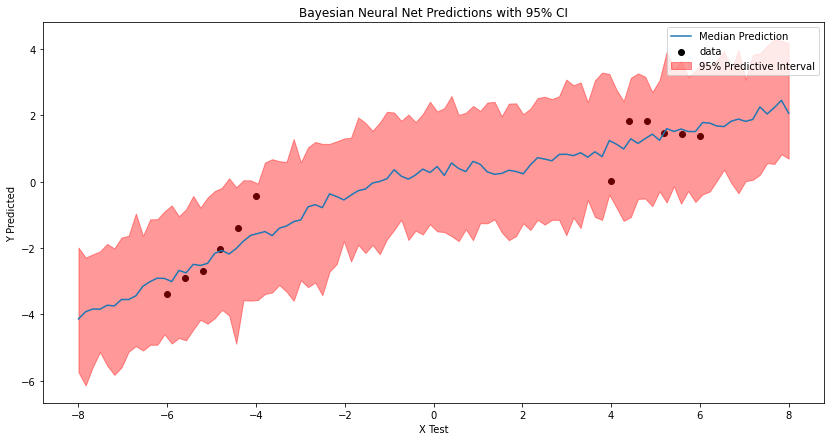

In [164]:
# Take 100 random posterior samples
w_random_samples = bayesian_lv_weights[np.random.choice(bayesian_lv_weights.shape[0], 100), :]

y_preds = []

# Loop through the samples of weights
for i in range(w_random_samples.shape[0]):
    # Create the same NN for predictions but with weights from the samples
    w_cur = w_random_samples[i,:]

    mu_pred = bnn_lv.forward(x_test_q3.reshape(-1,1), w_cur)
    y_pred = mu_pred
    y_preds.append(y_pred.reshape(-1))

# Calculate percentiles
y_lower = np.percentile(y_preds, q=2.5, axis=0)
y_upper = np.percentile(y_preds, q=97.5, axis=0)
y_med = np.percentile(y_preds, q=50, axis=0)

# Plot with confidence
plt.figure(figsize=(14,7))
plt.scatter(X_train.flatten(), y_train.flatten(), color='black', label='data')
plt.plot(x_test_q3, y_med, label="Median Prediction")
plt.fill_between(x_test_q3, y_lower, y_upper, alpha=0.4, color='r', label="95% Predictive Interval")
plt.title("Bayesian Neural Net Predictions with 95% CI")
plt.xlabel("X Test")
plt.ylabel("Y Predicted")
plt.legend()
plt.show()